## Dataset Preprocessing

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN # SMOTE
from imblearn.over_sampling import SMOTE # SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

loading in csv files

In [79]:
injuries_df = pd.read_csv('C:/Users/lalaf/OneDrive/Brown/Fall2024/Data1030/NFL-Injury-Risk-Analysis/data/InjuryRecord.csv')
plays_df = pd.read_csv('C:/Users/lalaf/OneDrive/Brown/Fall2024/Data1030/NFL-Injury-Risk-Analysis/data/PlayList.csv')

creating one df with "true/false" injury column

In [80]:
# injuries_df.head
# plays_df.head

injury_plays = plays_df.copy()
injury_plays['InjuryStatus'] = [key in list(injuries_df['PlayKey']) for key in injury_plays['PlayKey']]

print(injury_plays.head)

injury_plays.to_csv('Injury_Plays.csv', index=False)

<bound method NDFrame.head of         PlayerKey    GameID      PlayKey RosterPosition  PlayerDay  \
0           26624   26624-1    26624-1-1    Quarterback          1   
1           26624   26624-1    26624-1-2    Quarterback          1   
2           26624   26624-1    26624-1-3    Quarterback          1   
3           26624   26624-1    26624-1-4    Quarterback          1   
4           26624   26624-1    26624-1-5    Quarterback          1   
...           ...       ...          ...            ...        ...   
267000      47888  47888-13  47888-13-51     Cornerback         99   
267001      47888  47888-13  47888-13-52     Cornerback         99   
267002      47888  47888-13  47888-13-53     Cornerback         99   
267003      47888  47888-13  47888-13-54     Cornerback         99   
267004      47888  47888-13  47888-13-55     Cornerback         99   

        PlayerGame StadiumType  FieldType  Temperature         Weather  \
0                1     Outdoor  Synthetic           63 

**Visualization**

In [81]:
# ONLY keeping colums that are static throughout a game
# Merge based on PlayerKey and GameID (might result in duplicates)
merged_injury_data = pd.merge(
    injuries_df, 
    plays_df[['PlayerKey', 'GameID', 'RosterPosition', 'PlayerDay', 'PlayerGame', 'StadiumType', 'FieldType',
              'Temperature', 'Weather']],
    how='left', on=['PlayerKey', 'GameID']
)

# Drop duplicates, keeping the first occurrence of each PlayerKey and GameID combination
merged_injury_data = merged_injury_data.drop_duplicates(subset=['PlayerKey', 'GameID'])

# Check the result
print(merged_injury_data)


      PlayerKey    GameID     PlayKey BodyPart    Surface  DM_M1  DM_M7  \
0         39873   39873-4  39873-4-32     Knee  Synthetic      1      1   
32        46074   46074-7  46074-7-26     Knee    Natural      1      1   
58        36557   36557-1  36557-1-70    Ankle  Synthetic      1      1   
128       46646   46646-3  46646-3-30    Ankle    Natural      1      0   
158       43532   43532-5  43532-5-69    Ankle  Synthetic      1      1   
...         ...       ...         ...      ...        ...    ...    ...   
3292      44423  44423-13         NaN     Knee  Synthetic      1      0   
3319      31933  31933-20         NaN     Knee  Synthetic      1      0   
3345      47285   47285-4         NaN     Knee    Natural      1      1   
3361      37068  37068-19         NaN     Knee    Natural      1      1   
3381      36696  36696-24         NaN     Knee  Synthetic      1      1   

      DM_M28  DM_M42 RosterPosition  PlayerDay  PlayerGame        StadiumType  \
0          1      

        PlayerKey    GameID      PlayKey RosterPosition  PlayerDay  \
7162        31070   31070-1    31070-1-1   Running Back          1   
7163        31070   31070-1    31070-1-2   Running Back          1   
7164        31070   31070-1    31070-1-3   Running Back          1   
7165        31070   31070-1    31070-1-4   Running Back          1   
7166        31070   31070-1    31070-1-5   Running Back          1   
...           ...       ...          ...            ...        ...   
266372      47813  47813-11  47813-11-61     Cornerback        113   
266373      47813  47813-11  47813-11-62     Cornerback        113   
266374      47813  47813-11  47813-11-63     Cornerback        113   
266375      47813  47813-11  47813-11-64     Cornerback        113   
266376      47813  47813-11  47813-11-65     Cornerback        113   

        PlayerGame       StadiumType  FieldType  Temperature Weather PlayType  \
7162             1          Outdoors    Natural           67   Sunny     Punt 

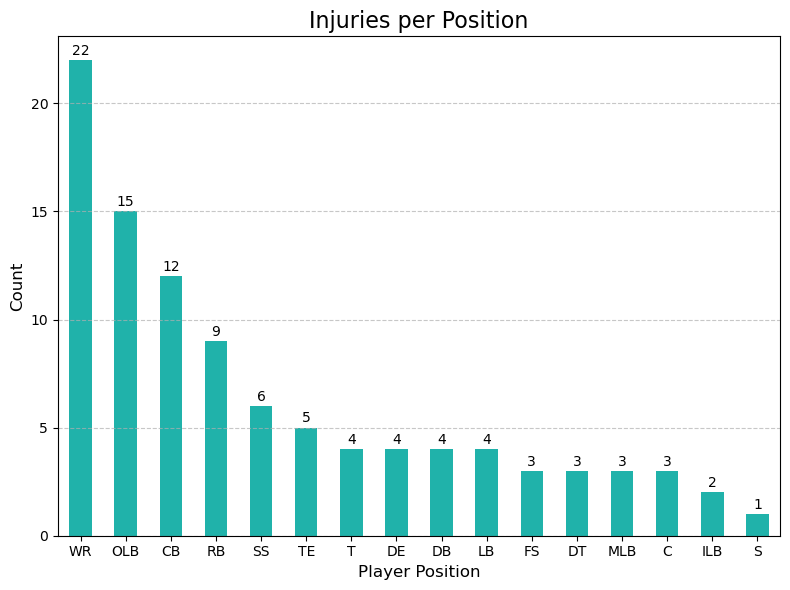

In [82]:
# Get subset dataframe of only injured players' plays
play_data_subset = plays_df[plays_df['PlayerKey'].isin(injuries_df['PlayerKey'])]
print(play_data_subset)
play_data_subset.to_csv('JustInjured.csv', index=False)

# Eliminate duplicates - not looking for play chronology atm; want position of each injured player
play_data_subset = play_data_subset.drop_duplicates(subset=['PlayerKey'])
print(play_data_subset)

# Get positions of those 100 injured players
pos_counts = play_data_subset['Position'].value_counts()
plt.figure(figsize=(8, 6))
bars = pos_counts.plot(kind='bar', color=['lightseagreen'])
plt.title('Injuries per Position', fontsize=16)
plt.xlabel('Player Position', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations above each bar
for i, count in enumerate(pos_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [83]:

print(merged_injury_data['Temperature'].describe())

# Replace -999 with NaN in the 'Temperature' column
merged_injury_data['Temperature'] = merged_injury_data['Temperature'].replace(-999, np.nan)

print(merged_injury_data['Temperature'].describe())



count    104.000000
mean     -16.480769
std      285.395926
min     -999.000000
25%       46.750000
50%       68.000000
75%       76.000000
max       89.000000
Name: Temperature, dtype: float64
count    96.000000
mean     65.395833
std      15.600593
min      33.000000
25%      54.500000
50%      68.000000
75%      78.000000
max      89.000000
Name: Temperature, dtype: float64


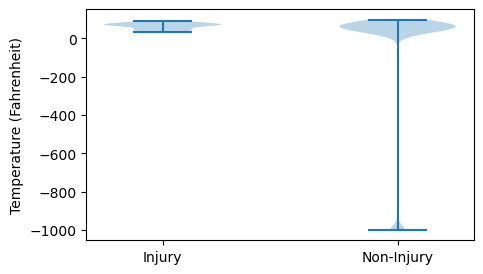

In [84]:
dataset = [merged_injury_data['Temperature'].dropna().values,
           injury_plays[injury_plays['InjuryStatus']==False]['Temperature'].dropna().values]

plt.figure(figsize=(5,3))

plt.violinplot(dataset=dataset)
plt.xticks([1, 2], ['Injury', 'Non-Injury'])
plt.ylabel('Temperature (Fahrenheit)')
plt.show()

In [85]:
print(injury_plays['PlayerGamePlay'].describe())

count    267005.000000
mean         29.058647
std          19.626551
min           1.000000
25%          13.000000
50%          26.000000
75%          43.000000
max         102.000000
Name: PlayerGamePlay, dtype: float64


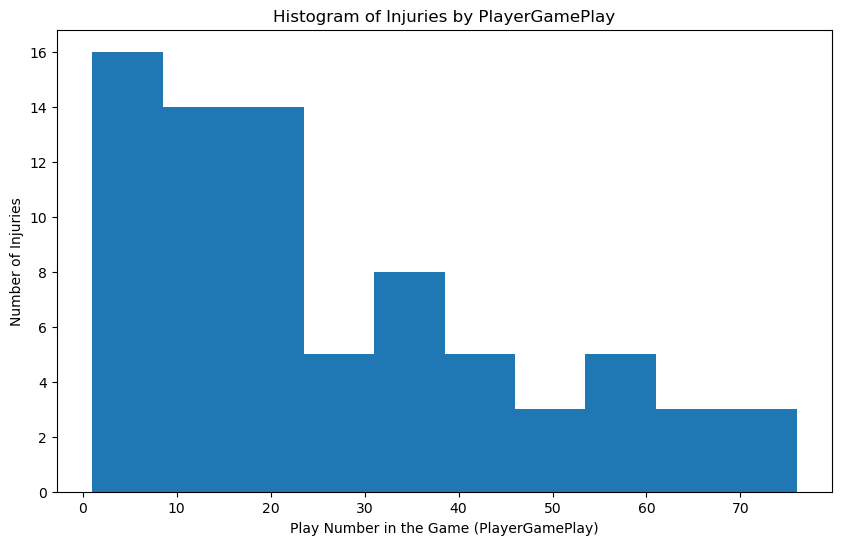

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the dataset is loaded into a DataFrame 'df'
# InjuryStatus is True for injured plays, False otherwise

# Step 1: Filter for injury plays (where InjuryStatus is True)
injury_data = injury_plays[injury_plays['InjuryStatus'] == True]

# Step 2: Plot a histogram of the PlayerGamePlay column for injury plays
plt.figure(figsize=(10, 6))
plt.hist(injury_data['PlayerGamePlay'], bins=10)
plt.title('Histogram of Injuries by PlayerGamePlay')
plt.xlabel('Play Number in the Game (PlayerGamePlay)')
plt.ylabel('Number of Injuries')
plt.show()


(76, 15)


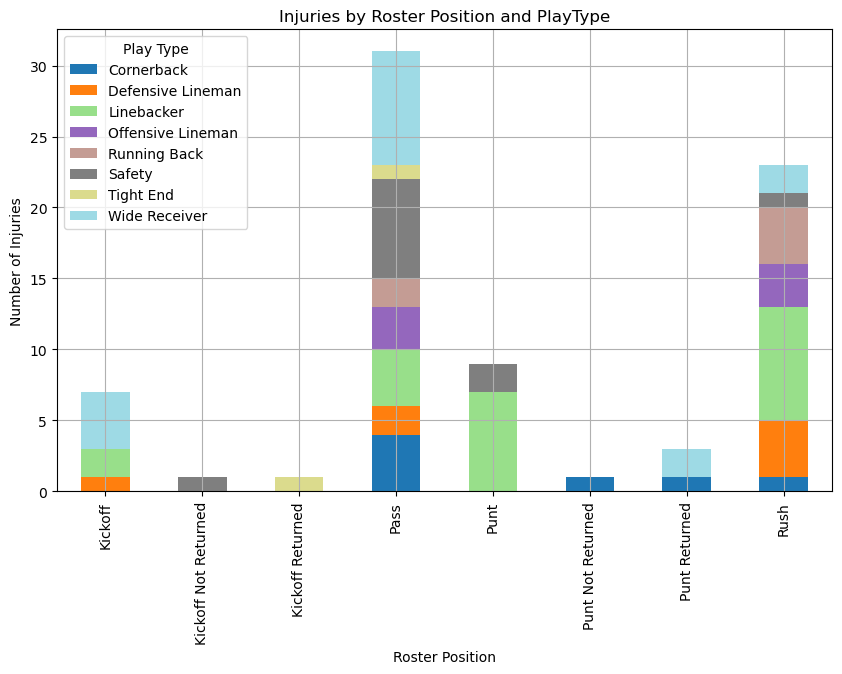

In [87]:
# Filter for only injury plays (InjuryStatus == True)
injury_data = injury_plays[injury_plays['InjuryStatus'] == True]
print(injury_data.shape)

# Group by RosterPosition and PlayType
grouped_data = injury_data.groupby(['PlayType', 'RosterPosition']).size().unstack(fill_value=0)

# Plot a stacked bar plot
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title('Injuries by Roster Position and PlayType')
plt.xlabel('Roster Position')
plt.ylabel('Number of Injuries')
plt.grid(True)
plt.legend(title='Play Type')
plt.show()


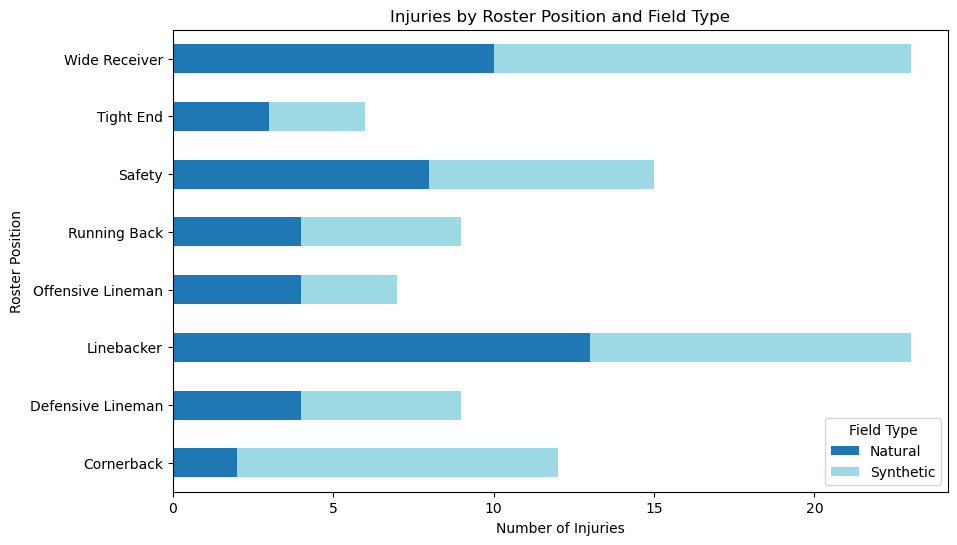

In [88]:
# Filter for only injury plays (InjuryStatus == True)
#injury_data = injury_plays[injury_plays['InjuryStatus'] == True]

# Group by PositionGroup and FieldType
grouped_data = merged_injury_data.groupby(['RosterPosition', 'FieldType']).size().unstack(fill_value=0)

# Plot a stacked bar plot
grouped_data.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title('Injuries by Roster Position and Field Type')
plt.ylabel('Roster Position')
plt.xlabel('Number of Injuries')
plt.legend(title='Field Type')
plt.show()

# changed to roster position cuz missing player keys


## One-Hot Encoding

In [89]:

# some string values have different meanings of the same thing - fix

# Stadium - indoor or outdoor
INDOOR = ['Closed Dome', 'Dome', 'Dome, closed', 'Domed', 'Domed, closed', 'Indoor', 'Indoor, Roof Closed',
          'Indoors', 'Retr. Roof - Closed', 'Retr. Roof Closed', 'Retr. Roof-Closed']
OUTDOOR = ['Bowl', 'Cloudy', 'Domed, Open', 'Domed, open', 'Heinz Field', 'Indoor, Open Roof', 'Open',
           'Oudoor', 'Ourdoor', 'Outddors', 'Outdoor', 'Outdoor Retr Roof-Open', 'Outdoors', 'Outdor',
           'Outside', 'Retr. Roof - Open', 'Retr. Roof-Open', 'Retractable Roof']
injury_plays['StadiumType'] = ['Indoor' if k in INDOOR
                               else 'Outdoor' if k in OUTDOOR
                               else 'NAN' for k in injury_plays['StadiumType']]
injury_plays = injury_plays[injury_plays['StadiumType'] != 'NAN']

# Weather - Clear, Rain, Clouds, Snow, or Indoor
CLEAR = ['Clear','Clear Skies','Clear and Cool','Clear and Sunny','Clear and cold','Clear and sunny',
         'Clear and warm', 'Clear skies', 'Clear to Partly Cloudy', 'Cold', 'Fair', 'Heat Index 95',
         'Mostly Sunny', 'Mostly Sunny Skies', 'Mostly sunny', 'Partly Sunny', 'Partly clear',
         'Partly sunny', 'Sun & clouds', 'Sunny', 'Sunny Skies', 'Sunny and clear', 'Sunny and cold',
         'Sunny and warm', 'Sunny, Windy', 'Sunny, highs to upper 80s']
RAIN = ['10% Chance of Rain', '30% Chance of Rain', 'Showers',
        'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Cloudy, 50% change of rain', 'Cloudy, Rain', 'Cloudy, chance of rain', 'Light Rain', 'Rain',
        'Rain Chance 40%', 'Rain likely, temps in low 40s.', 'Rain shower', 'Rainy', 'Scattered Showers']
CLOUDS = ['Cloudy', 'Cloudy and Cool', 'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
          'Coudy', 'Hazy', 'Mostly Cloudy', 'Mostly Coudy', 'Mostly cloudy', 'Overcast', 'Partly Cloudy',
          'Partly Clouidy', 'Partly cloudy', 'Party Cloudy', 'cloudy']
SNOW = ['Cloudy, light snow accumulating 1-3"', 'Heavy lake effect snow', 'Snow']
INDOORS = ['Controlled Climate', 'Indoor', 'Indoors', 'N/A (Indoors)', 'N/A Indoor']
injury_plays['Weather'] = ['Clear' if k in CLEAR
                           else 'Rain' if k in RAIN
                           else 'Clouds' if k in CLOUDS
                           else 'Snow' if k in SNOW
                           else 'Indoor' if k in INDOORS
                           else 'NAN' for k in injury_plays['Weather']]
injury_plays = injury_plays[injury_plays['Weather'] != 'NAN']

# Play Type
PUNT = ['Punt', 'Punt Returned', 'Punt Not Returned']
KICKOFF = ['Kickoff', 'Kickoff Returned', 'Kickoff Not Returned']
injury_plays['PlayType'] = ['Punt' if k in PUNT
                            else 'Kickoff' if k in KICKOFF
                            else k for k in injury_plays['PlayType']]

injury_plays = injury_plays[injury_plays['PlayType'] != '0']
injury_plays = injury_plays[injury_plays['Position'] != 'Missing Data']
injury_plays = injury_plays[injury_plays['PositionGroup'] != 'Missing Data']
injury_plays = injury_plays[injury_plays['PlayerDay'] != np.nan]
injury_plays = injury_plays[injury_plays['PlayerGame'] != np.nan]
injury_plays = injury_plays[injury_plays['PlayerGamePlay'] != np.nan]
injury_plays = injury_plays[injury_plays['Temperature'] != np.nan]

In [98]:
# Step 1: Define feature columns
feature_cols = ['RosterPosition', 'PlayerDay', 'PlayerGame', 'StadiumType','FieldType','Temperature','Weather','PlayType','PlayerGamePlay','Position','PositionGroup']
X = injury_plays[feature_cols]
y = injury_plays['InjuryStatus']

groups = injury_plays['PlayerKey']
print(groups.head())  # Check the first few values in the groups column

# Step 2: Split the data using GroupShuffleSplit (train/test split)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=17)
for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

# Step 3: Define categorical and numerical columns
categorical_cols = ['RosterPosition', 'StadiumType', 'FieldType', 'Weather', 'PlayType', 'Position', 'PositionGroup']
numerical_cols = ['PlayerDay', 'PlayerGame', 'Temperature', 'PlayerGamePlay']

# Step 4: Initialize OneHotEncoder and StandardScaler
# Combine transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), 
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical features
    ])

# Step 5: Fit the preprocessor on the training data and transform both training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
print("Class distribution before ADASYN:", np.bincount(y_train))


# Step 6: Apply ADASYN for oversampling the minority class in the training data
adasyn = ADASYN(random_state=17)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_transformed, y_train)

# Check the new class distribution after ADASYN
print("Class distribution after ADASYN:", np.bincount(y_train_resampled))

# Step 7: GroupKFold for cross-validation within the training set (if needed)
group_kfold = GroupKFold(n_splits=5)
fold = 1
for train_idx, val_idx in group_kfold.split(X_train_transformed, y_train, groups=groups_train):
    X_train_fold, X_val_fold = X_train_transformed[train_idx], X_train_transformed[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Print the fold number
    print(f"Fold {fold} completed.")
    fold += 1

# Now, X_train_transformed and X_test_transformed contain both scaled and one-hot encoded features

0    26624
1    26624
2    26624
3    26624
4    26624
Name: PlayerKey, dtype: int64
Class distribution after ADASYN: [180131     51]
Class distribution after ADASYN: [180131 180129]
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Fold 5 completed.


## checking

In [100]:
# Check the size of the train and test sets
print(f"X_train size: {X_train.shape}")
print(f"X_test size: {X_test.shape}")

# # Check that no `PlayerKey` values are shared between train and test
print("Shared PlayerKey values between train and test:", set(groups_train).intersection(set(groups_test)))

# # Check the shape of the transformed data after OneHotEncoding
# print(f"X_train transformed shape: {X_train_transformed.shape}")
# print(f"X_test transformed shape: {X_test_transformed.shape}")

# # Optionally, view the first few rows of the transformed training data
# print(pd.DataFrame(X_train_transformed).head())

# # Check the feature names of the one-hot encoded columns
# print(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Extract the scaled numerical columns from the transformed training data
scaled_columns = preprocessor.named_transformers_['num'].transform(X_train[numerical_cols])
# Run through the GroupKFold splits and ensure no groups are shared
for train_idx, val_idx in group_kfold.split(X_train_transformed, y_train, groups=groups_train):
    train_groups = groups_train.iloc[train_idx]
    val_groups = groups_train.iloc[val_idx]

    # Ensure no PlayerKey is shared between the train and validation sets
    shared_groups = set(train_groups).intersection(set(val_groups))
    print(f"Shared PlayerKey values in fold: {shared_groups}")


X_train size: (180182, 11)
X_test size: (51857, 11)
Shared PlayerKey values between train and test: set()
Shared PlayerKey values in fold: set()
Shared PlayerKey values in fold: set()
Shared PlayerKey values in fold: set()
Shared PlayerKey values in fold: set()
Shared PlayerKey values in fold: set()


In [ ]:
# categoricals = ['RosterPosition','StadiumType','FieldType','Weather','PlayType','Position','PositionGroup']
# # Extract the categorical columns from your dataset
# X_categorical = injury_plays[categoricals]

# # Initialize the OneHotEncoder
# enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # handle_unknown='ignore' ensures unknown categories in test set won't cause errors

# # Fit the encoder on the categorical data
# enc.fit(X_categorical)

# # Transform the training data
# X_categorical_ohe = enc.transform(X_categorical)

# # Convert the one-hot encoded output back to a DataFrame for easier use
# X_categorical_ohe_df = pd.DataFrame(X_categorical_ohe, columns=enc.get_feature_names_out(categoricals))

# # Now you can concatenate the one-hot encoded columns back to the rest of your dataset
# # Assuming you also have other continuous features, you could do:
# X_numeric = injury_plays.drop(columns=categoricals)  # Non-categorical columns
# X_final = pd.concat([X_numeric.reset_index(drop=True), X_categorical_ohe_df.reset_index(drop=True)], axis=1)

# # Print the transformed dataset
# print(X_final.head())

## Splitting the data

In [69]:
# feature_cols = ['RosterPosition', 'PlayerDay', 'PlayerGame', 'StadiumType','FieldType','Temperature','Weather','PlayType','PlayerGamePlay','Position','PositionGroup']
# X = injury_plays[feature_cols]
# y = injury_plays['InjuryStatus']

# groups = injury_plays['PlayerKey']


# print("Length of X:", len(X))
# print("Length of y:", len(y))
# print("Length of groups:", len(groups))

Length of X: 131727
Length of y: 131727
Length of groups: 131727


In [72]:


# # Step 1: GroupShuffleSplit for train/test split
# gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_idx, test_idx in gss.split(X, y, groups):
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
#     groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

# # Step 2: Scale the data (fit only on training data)
# scaler = StandardScaler()

# # Fit the scaler on the training data
# X_train_scaled = scaler.fit_transform(X_train)

# # Apply the scaler to the test data (transform only, without fitting)
# X_test_scaled = scaler.transform(X_test)

# # Step 3: GroupKFold for cross-validation within the training set (if needed)
# group_kfold = GroupKFold(n_splits=5)
# fold = 1
# for train_idx, val_idx in group_kfold.split(X_train_scaled, y_train, groups=groups_train):
#     X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
#     y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
   
#     # Only print the fold number
#     print(f"Fold {fold} completed.")
#     fold += 1

Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Fold 5 completed.
